# EDA 2
---  
-> saving processed file path [./data/processed0903/](../data/processed0903/)

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
import warnings 
%matplotlib inline 
warnings.filterwarnings("ignore")

Duplicate key in file PosixPath('/home/kooose/.local/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 261 ('font.serif:      DejaVu Serif, Bitstream Vera Serif, Computer Modern Roman, New Century Schoolbook, Century Schoolbook L, Utopia, ITC Bookman, Bookman, Nimbus Roman No9 L, Times New Roman, Times, Palatino, Charter, serif')
Duplicate key in file PosixPath('/home/kooose/.local/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 262 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')


In [2]:
train = pd.read_csv("./data/raw/train.csv")
test = pd.read_csv("./data/raw/test.csv")
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


In [3]:
train["datetime"] = pd.to_datetime(train.datetime)
test["datetime"] = pd.to_datetime(test.datetime)

train["year"] = train.datetime.dt.year 
train["month"] = train.datetime.dt.month
train["quarter"] = train.datetime.dt.quarter 
test["month"] = test.datetime.dt.month
train["day"] = train.datetime.dt.day
test["day"] = test.datetime.dt.day
train["day"] = (train.day -1)/ (31-1)
test["day"] = (test.day -1)/ (31-1)
train = train[train.year == 2014]
train.drop(["year"], axis=1, inplace=True)

train["carry"] = train.name.str.find("カレー") > 0
test["carry"] = test.name.str.find("カレー") > 0
train["carry"] = train.carry.astype(int)
test["carry"] = test.carry.astype(int)
train["quarter"] = train.datetime.dt.quarter 
test["quarter"] = test.datetime.dt.quarter


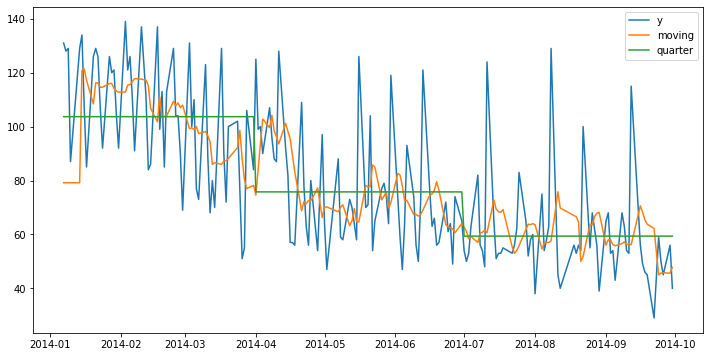

In [4]:
def q_mean(x):
    return train.loc[train.quarter == x, "y"].mean()
train["moving_avg"] = train.y.shift(1).rolling(window=5).mean()
train["moving_avg"] = train.moving_avg.fillna(train.moving_avg.mean())
test["moving_avg"] = train.loc[train.quarter == 3, "moving_avg"].mean() - 10 # 減少傾向にあるので将来時点でもさらに下がると予想されるため.
train["q_mean"] = train.quarter.apply(lambda x: q_mean(x))
plt.figure(figsize=(12, 6))
plt.plot(train.set_index("datetime").y)
plt.plot(train.set_index("datetime").moving_avg)
plt.plot(train.set_index("datetime").q_mean)
plt.legend(["y", "moving", "quarter"])
plt.show()
train.drop("q_mean", axis=1, inplace=True)

<AxesSubplot:xlabel='month', ylabel='kcal'>

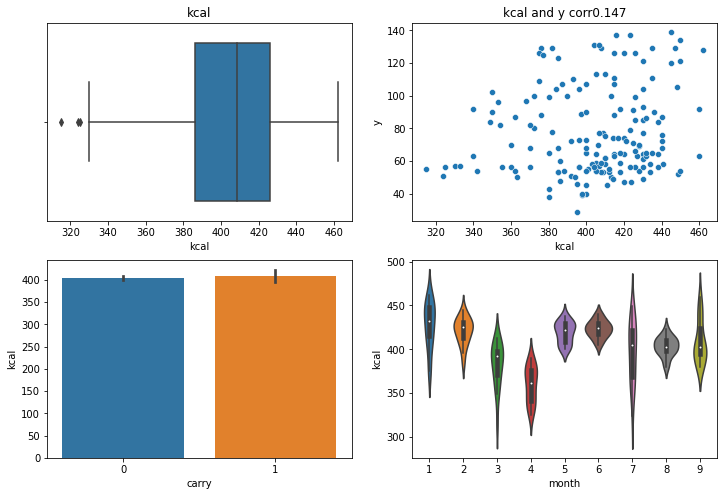

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax = axes.ravel()
sns.boxplot(train.kcal, ax=ax[0])
ax[0].set_title("kcal")
sns.scatterplot(data=train, x="kcal", y="y", ax=ax[1])
corr = train[["kcal", "y"]].corr().iloc[0, 1]
ax[1].set_title(f"kcal and y corr{corr:.3f}")
sns.barplot(data=train, x="carry", y="kcal", ax=ax[2])
sns.violinplot(data=train, x="month", y="kcal", ax=ax[3])

In [6]:
def month_kcal_mean(x):
    return train.loc[train.month == x, "kcal"].mean()

def calc():
    index, values = [], []
    for month in train.month.value_counts().index.to_list():
        index.extend(train.loc[train.month == month, "kcal"].fillna(month_kcal_mean(month)).index)
        values.extend(train.loc[train.month == month, "kcal"].fillna(month_kcal_mean(month)).values)
    return index, values
index, values = calc()
kcal = pd.DataFrame({"kcal": values}, index=index).sort_index()
train = pd.merge(train, kcal, how="outer", left_index=True, right_index=True).drop("kcal_x", axis=1).rename(columns={"kcal_y": "kcal"})
test["kcal"] = test.kcal.fillna(train.kcal.mean())

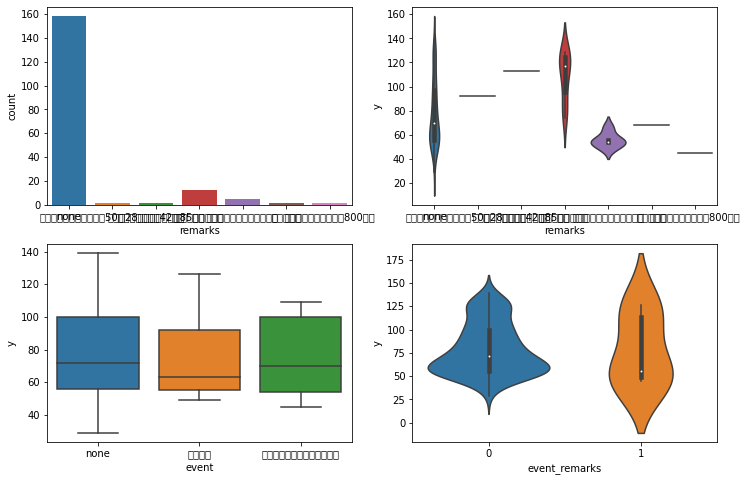

In [7]:
train["remarks"] = train.remarks.fillna("none")
train["event"] = train.event.fillna("none")
train["payday"] = train.payday.fillna(0)
test["remarks"] = test.remarks.fillna("none")
test["event"] = test.event.fillna("none")
test["payday"] = test.payday.fillna(0)

train["event_remarks"] = train.isin(train[(train.remarks != "none") & (train.event != "none")])["y"].astype(int)
test["event_remarks"] = test.isin(test[(test.remarks != "none") & (test.event != "none")])["remarks"].astype(int)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax = axes.ravel()
sns.countplot(train.remarks, ax=ax[0])
sns.violinplot(data=train, x="remarks", y="y", ax=ax[1])
sns.boxplot(data=train, x="event", y="y", ax=ax[2])
sns.violinplot(data=train, x="event_remarks", y="y", ax=ax[3])

def ch_remarks(x):
    x = x.strip()
    if x in ["お楽しみメニュー"]:
        return 1
    else:
        return 0 
    
train.drop("event", axis=1, inplace=True)
test.drop("event", axis=1, inplace=True)
train["remarks"] = train.remarks.apply(lambda x: ch_remarks(x))
test["remarks"] = test.remarks.apply(lambda x: ch_remarks(x))

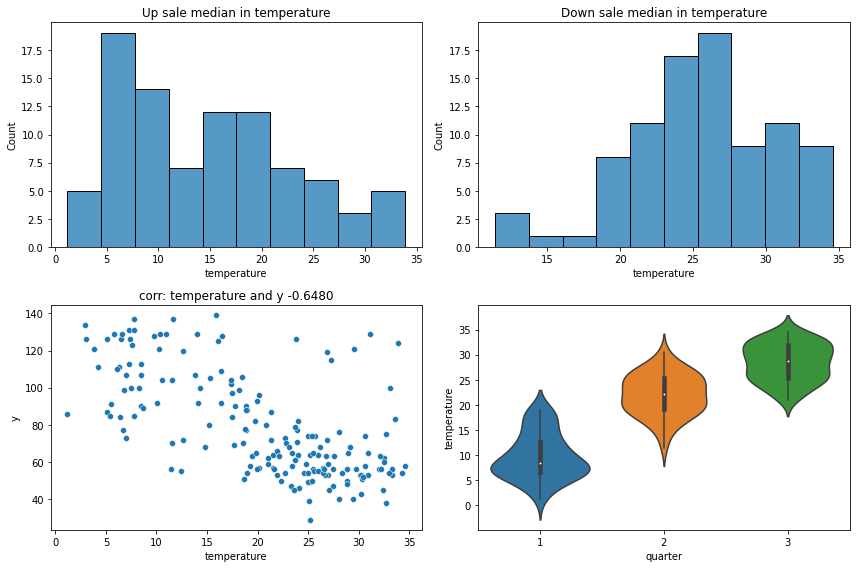

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax = axes.ravel()

def mean_tem_month(x):
    return train.loc[train.quarter == x, "temperature"].mean()

sns.histplot(train[train.y >= train.y.median()].temperature, ax=ax[0], bins=10)
ax[0].set_title(f"Up sale median in temperature")
sns.histplot(train[train.y < train.y.median()].temperature, ax=ax[1], bins=10)
ax[1].set_title(f"Down sale median in temperature")
sns.scatterplot(data=train, x="temperature", y="y", ax=ax[2])
corr = train[["y", "temperature"]].corr().iloc[0, 1]
ax[2].set_title(f"corr: temperature and y {corr:.4f}")
sns.violinplot(data=train, x="quarter", y="temperature")

plt.tight_layout()

In [9]:
q1 = mean_tem_month(1)
q2 = mean_tem_month(2)
q3 = mean_tem_month(3)

train.loc[train.quarter == 1, "mean_tem"] = q1
train.loc[train.quarter == 2, "mean_tem"] = q2
train.loc[train.quarter == 3, "mean_tem"] = q3

t = pd.read_csv("./data/raw/train.csv")
t["datetime"] = pd.to_datetime(t.datetime)
t["year"] = t.datetime.dt.year 
t = t[t.year == 2013]
tem_mean_2013 = t.temperature.mean()

test["mean_tem"] = tem_mean_2013 
train["mean_tem"] = train.temperature/train.mean_tem
test["mean_tem"] = test.temperature/test.mean_tem 

<AxesSubplot:xlabel='mean_tem'>

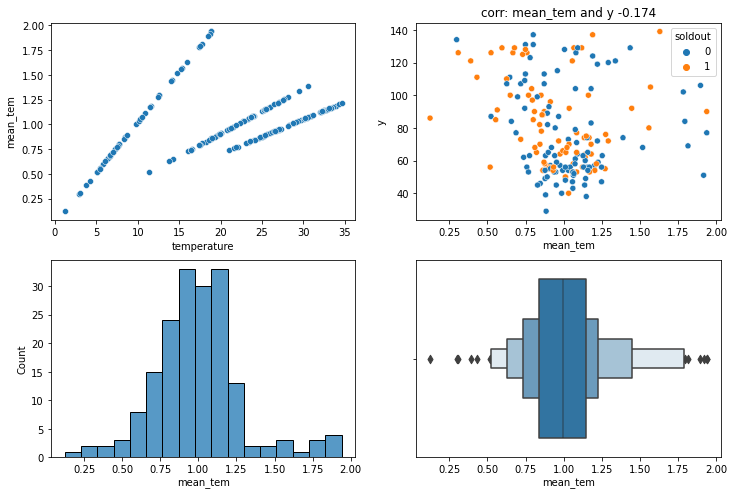

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax = axes.ravel()

sns.scatterplot(data=train, x="temperature", y="mean_tem", ax=ax[0])
sns.scatterplot(data=train, x="mean_tem", y="y", ax=ax[1], hue="soldout")
corr = train[["mean_tem", "y"]].corr().iloc[0, 1]
ax[1].set_title(f"corr: mean_tem and y {corr:.3f}")
sns.histplot(train.mean_tem, ax=ax[2])
sns.boxenplot(train.mean_tem)

In [11]:
cols = ["week", "weather"]
for col in cols:
    la = LabelEncoder()
    la.fit(train[col])
    train[col] = la.transform(train[col])
    test[col] = la.transform(test[col])
    print(la.classes_)
    
train["precipitation"] = train.precipitation.apply(lambda x: 0 if x == "--" else x)
test["precipitation"] = test.precipitation.apply(lambda x: 0 if x == "--" else x)
train.drop(["datetime", "name"], axis=1, inplace=True)
test.drop(["datetime", "name"], axis=1, inplace=True)

['月' '木' '水' '火' '金']
['快晴' '晴れ' '曇' '薄曇' '雨' '雪' '雷電']


<Figure size 864x360 with 0 Axes>

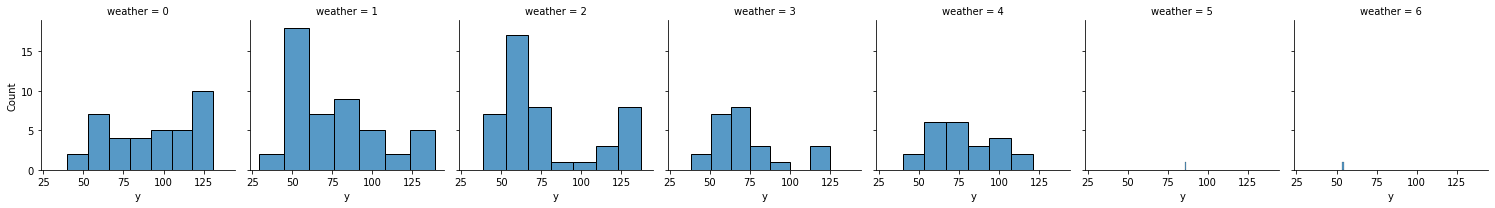

In [12]:
train["before1day_weather"] = train.weather.shift(1).fillna(train.weather.mode()[0])
test["before1day_weather"] = test.weather.shift(1).fillna(train.weather.mode()[0])
plt.figure(figsize=(12, 5))
g = sns.FacetGrid(data=train, col="weather")
g.map(sns.histplot, "y")

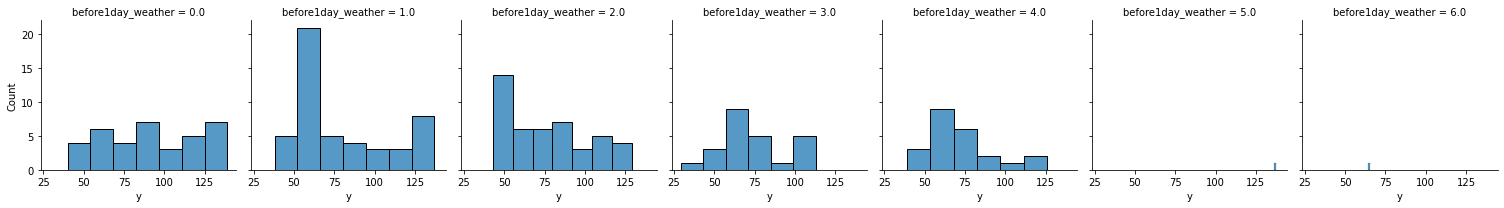

In [13]:
g = sns.FacetGrid(data=train, col="before1day_weather")
g.map(sns.histplot, "y")

Text(0.5, 1.0, 'corr: moving_avg and y 0.6220')

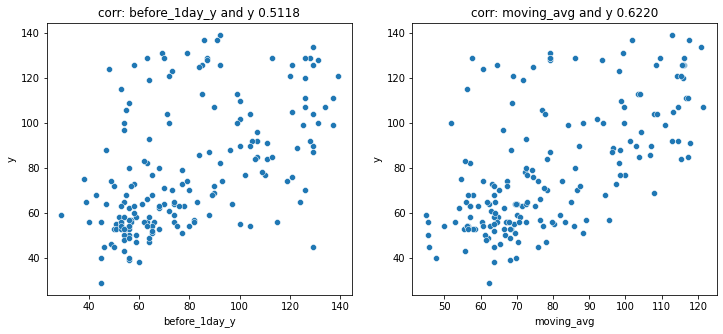

In [14]:
train["before_1day_y"] = train.y.shift(1).fillna(train.y.mean())
final_train_y = train.loc[206, "y"]
test.loc[0, "before_1day_y"] = final_train_y

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=train, x="before_1day_y", y="y", ax=ax[0])
corr = train[["before_1day_y", "y"]].corr().iloc[0, 1]
ax[0].set_title(f"corr: before_1day_y and y {corr:.4f}")
sns.scatterplot(data=train, x="moving_avg", y="y", ax=ax[1])
corr = train[["moving_avg", "y"]].corr().iloc[0, 1]
ax[1].set_title(f"corr: moving_avg and y {corr:.4f}")

In [15]:
len(train.columns) == len(test.columns)+1

True

In [16]:
train.head()

,y,week,soldout,remarks,payday,weather,precipitation,temperature,month,quarter,day,carry,moving_avg,kcal,event_remarks,mean_tem,before1day_weather,before_1day_y
28,131,3,0,0,0.0,0,0,7.3,1,1,0.200000,0,79.171264,404.0,0,0.749055,1.0,79.162011
29,128,2,0,0,0.0,2,0,9.8,1,1,0.233333,0,79.171264,462.0,0,1.005581,0.0,131.000000
30,129,1,1,0,0.0,2,0,10.9,1,1,0.266667,0,79.171264,435.0,0,1.118452,2.0,128.000000
31,87,4,0,0,1.0,0,0,5.1,1,1,0.300000,0,79.171264,440.0,0,0.523312,2.0,129.000000
32,129,3,1,0,0.0,1,0,5.8,1,1,0.433333,0,79.171264,376.0,0,0.595140,0.0,87.000000


In [18]:
import os 
root_path = os.path.join("data", "processed0903")
train_ = train[train.month <= 7]
val = train[train.month > 7]

train_.to_csv(root_path+"/train.csv", index=False)
val.to_csv(root_path+"/val.csv", index=False)
test.to_csv(root_path+"/test.csv", index=False)